In [146]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import lmfit
from scipy import interpolate
from scipy import stats

Let's make a very simple setup where we have a signal and a background. We will define signal and background as :

$$
s^{x}_{i} \in \mathcal{N}(0,1) \\
s^{y}_{i} \in \mathcal{U}(0,1) \\
s^{z}_{i} \in \bigtriangleup(0,0.95,1) \\
b^{x}_{i} \in \mathcal{U}(-3,3)\\
b^{y}_{i} \in \mathcal{U}(0,1)\\
b^{z}_{i} \in \bigtriangleup(0,0.05,1)
$$

where $x,y,z$ denote the axes in x,y,z of this sample. $x$ will be our proxy for mass and $y$ will be an extra variable, that we aren't going to use for now, and $z$ is going to be our discriminating variable. Lets make a few plots and see how things look. 



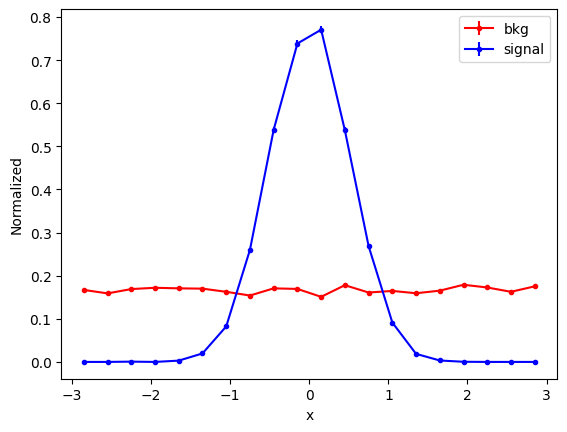

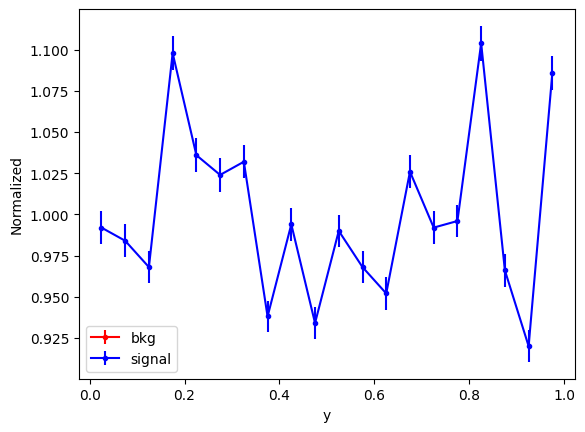

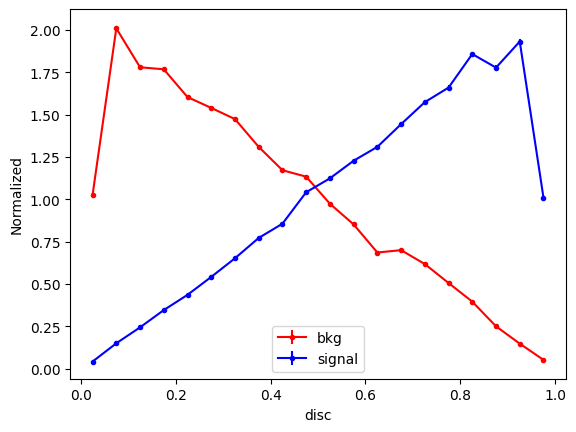

In [271]:
def plotHist(iSig,iBkg,iMin=-3,iMax=3,label="x"):
    ns=len(iSig)
    nb=len(iBkg)
    ys, bin_edges = np.histogram(iSig,density=True,bins=20,range=[iMin,iMax])#bins=bin_edges
    yb, bin_edges = np.histogram(iBkg, bins=bin_edges,density=True)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers,yb,yerr=(nb*yb)**0.5/nb,marker='.',linestyle = '-', color = 'red',label='bkg')
    plt.errorbar(bin_centers,ys,yerr=(ns*ys)**0.5/ns,marker='.',linestyle = '-', color = 'blue',label='signal')
    plt.xlabel(label)
    plt.ylabel("Normalized")
    plt.legend()
    plt.show()

def plotHistComp(iSig,iBkg,iGSig,iGBkg,iMin=-3,iMax=3):
    ns=len(iSig)
    nb=len(iBkg)
    ngs=len(iGSig)
    ngb=len(iGBkg)
    ys, bin_edges = np.histogram(iSig,density=True,bins=20,range=[iMin,iMax])#bins=bin_edges
    yb, bin_edges = np.histogram(iBkg, bins=bin_edges,density=True)
    ygs,bin_edges = np.histogram(iGSig, bins=bin_edges,density=True)
    ygb,bin_edges = np.histogram(iGBkg, bins=bin_edges,density=True)
    ygs*=len(iGSig)/len(iSig)
    ygb*=len(iGBkg)/len(iBkg)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers,yb,yerr=(nb*yb)**0.5/nb,marker='.',linestyle = '-', color = 'red',label='bkg')
    plt.errorbar(bin_centers,ys,yerr=(ns*ys)**0.5/ns,marker='.',linestyle = '-', color = 'blue',label='signal')
    plt.errorbar(bin_centers,ygb,yerr=(ngb/nb)*((ngb*ygb)**0.5)/ngb,marker='.',linestyle = '--', color = 'red',label='bkg(no cuts)')
    plt.errorbar(bin_centers,ygs,yerr=(ngs/ns)*((ngs*ygs)**0.5)/ngs,marker='.',linestyle = '--', color = 'blue',label='signal(no cuts)')
    plt.xlabel("x")
    plt.ylabel("Normalized")
    plt.legend()
    plt.show()
    
def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0,1,iNS)
    sz=np.random.triangular(0.,0.95, 1, iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,0,iNB)
    bz=np.random.triangular(0,0.05,1,iNB)
    b=np.vstack([bx,by,bz])
    return s,b

sig,bkg=genData(10000,10000)
plotHist(sig[0],bkg[0],label="x")
plotHist(sig[1],bkg[1],0,1,label="y")
plotHist(sig[2],bkg[2],0,1,label="disc")

Now lets do a quick check of the significance calculation, we will use lmfit

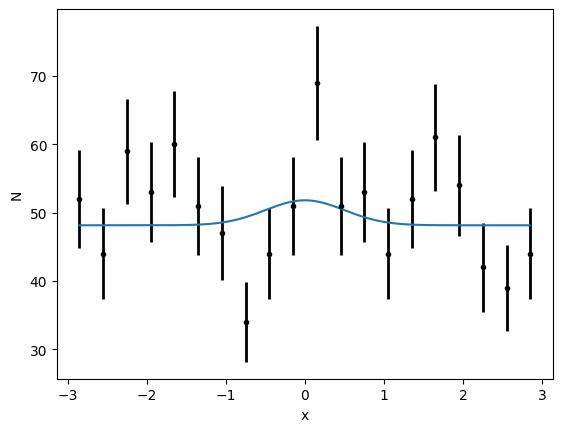

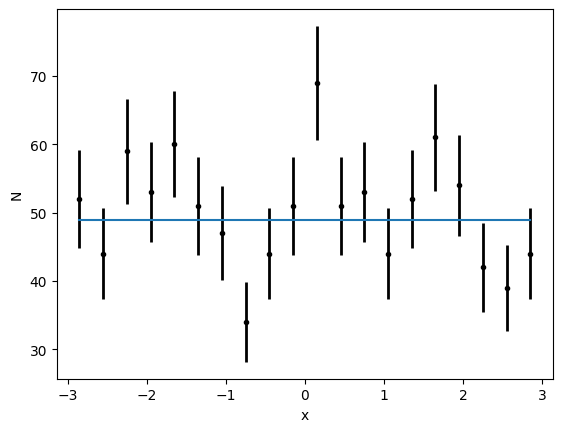

Delta negative Log Likelihood: 0.520138823729873
Our Probability of this happening 0.4707824697517725
Expected Sig: 0.7212065056070094 expected lim: 12.6670229347168 events 4.5773159638455825 events 18 sig events
0
Expected Limit: 12.413509636395958 events Best fit: -4.649384422567406 events 0 sig events


In [275]:
#now lets find 10% background and fit signal this will be our truth
def cutval(iData, p=0.9):
    datasort=np.sort(iData)
    ndata=len(datasort)
    return datasort[int(ndata*p)]


def makeCutDataHist(iD,iVar,iPlot=False):
    cut=cutval(iVar)
    data = iD[0][iVar > cut]
    y,  bin_edges = np.histogram(data, bins=20,range=[-3,3])
    x = 0.5*(bin_edges[1:] + bin_edges[:-1])
    if iPlot:
        plt.errorbar(x, y,yerr= y**0.5,marker='.',linestyle = 'None', color = 'black')
        plt.xlabel("x")
        plt.ylabel("N")
        plt.legend()
        plt.show()
    return x,y,cut

def fitData(iX,iY,iFunc,iSig=False,iAmpVal=0,iPlot=False):
    lFit   = lmfit.Model(iFunc)
    params = lmfit.Parameters()
    params.add('c',    value=125,min=0,max=np.inf)
    params.add('mu',   value=0,min=-3,max=3)
    params.add('sigma',value=0.5,min=0,max=2)
    params.add('amp',  value=0,min=-np.inf,max=np.inf)
    params["mu"].vary = False
    params["sigma"].vary = False
    if not iSig:
        params["amp"].value = iAmpVal
        params["amp"].vary  = False
    result = lFit.fit(iY,params,x=iX,weights=1./np.sqrt(iY))
    #lmfit.report_fit(result)
    if iPlot:
        #Now we plot it. 
        plt.errorbar(iX, iY,np.sqrt(iY), lw=2,fmt=".k", capsize=0)
        plt.plot(np.arange(iX[0],iX[-1],0.01),iFunc(np.arange(iX[0],iX[-1],0.01),
                                                    result.params['mu'],result.params['sigma'],result.params['amp'],result.params['c']))
        plt.xlabel("x")
        plt.ylabel("N")
        plt.show()
    return result.chisqr,result.params

def fNull(x,mu,sigma,amp,c):
    val = stats.norm.pdf(x,mu,sigma)
    return amp*val + c

def deltaNLL(x,y,iPlot=False):
    LLNull,_=fitData(x,y,fNull,True,0,iPlot)
    LLAlt,_=fitData(x,y,fNull,False,0,iPlot)
    return LLAlt-LLNull

def expLim(x,y,iPlot=False):
    _,params=fitData(x,y,fNull,True,0,iPlot)
    ampvalue=params['amp'].stderr
    bestfit=params['amp'].value
    xscale=np.array([])
    amparr=np.array([])
    LLNull,params=fitData(x,y,fNull,False,bestfit,iPlot)
    for pScale in np.arange(0.5,10,0.5):
        LLAlt0,_=fitData(x,y,fNull,False,bestfit+ampvalue*pScale,iPlot)
        #print("dChi2:",LLAlt0-LLNull)
        if LLAlt0 > LLNull:
            xscale=np.append(xscale,ampvalue*pScale)
            amparr=np.append(amparr,LLAlt0-LLNull)
    nllf = interpolate.make_interp_spline(amparr,xscale)
    if iPlot:
        plt.plot(amparr,xscale)
        plt.show()
    return nllf(4),bestfit

def significance(iX,iY,iPrint=False,iPlot=False):
    NLL = deltaNLL(iX,iY,iPlot)
    p   = 1-stats.chi2.cdf(NLL, 1)
    z   = -1*stats.norm.ppf(p/2.)
    if iPrint:
        print("Delta negative Log Likelihood:",NLL)
        print("Our Probability of this happening",p)
    return z

def asymlimit(iS,iB):
    tdata = np.hstack((iS,iB))
    xcut,ycut,cut=makeCutDataHist(tdata,tdata[2,:])
    lim,amp=expLim(xcut,ycut,False)
    sig=iS[0,iS[2,:] > cut]
    print(len(sig))
    return lim,amp,len(sig)
    
def expSigToy(iS,iB,iDebug=False): #No testing and training needed
    tdata = np.hstack((iS,iB))
    xcut,ycut,cut=makeCutDataHist(tdata,tdata[2,:])
    lim,amp=expLim(xcut,ycut,False)
    sig=iS[0,iS[2,:] > cut]
    #sig1=tdata[1,tdata[2,:] > cut]
    #sig1=sig1[sig1 > 0]
    return significance(xcut,ycut,iDebug,iDebug),lim,amp,len(sig)

#Quick test
pS,pB = genData(50,10000)
pVExpSig,pVLim,pAmp,pSig=expSigToy(pS,pB,True)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events",pAmp,"events",pSig,"sig events")
pS,pB = genData(0,10000)
pVLim0,pAmp,pSig = asymlimit(pS,pB)         
print("Expected Limit:",pVLim0,"events","Best fit:",pAmp,"events",pSig,"sig events")

Now that we our significance setting procedure, lets go ahead and build the deep learning algorithm for training so that we can see what is going on. Let's do the usual pytorch setup for training, and run a quick check that it is working.  

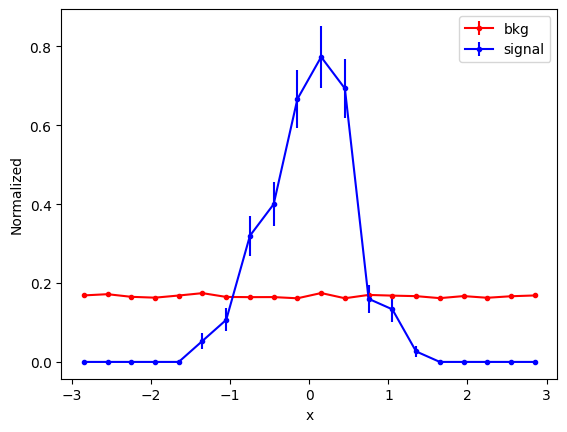

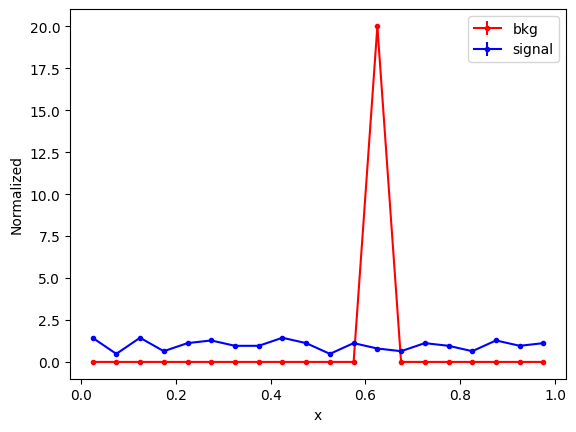

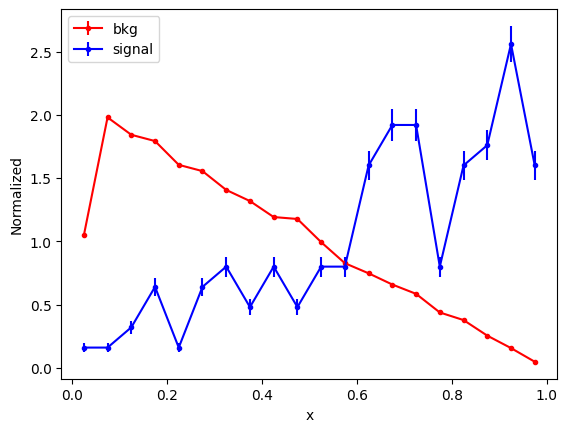

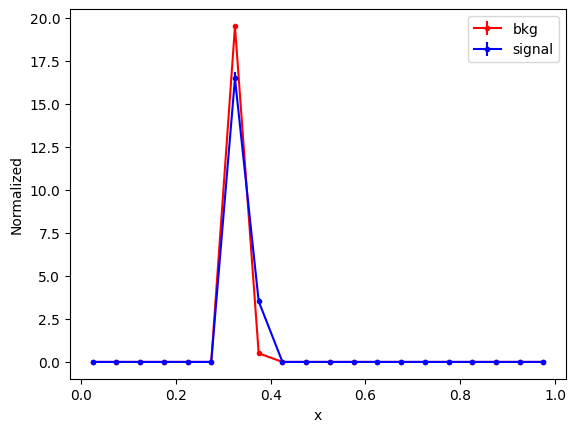

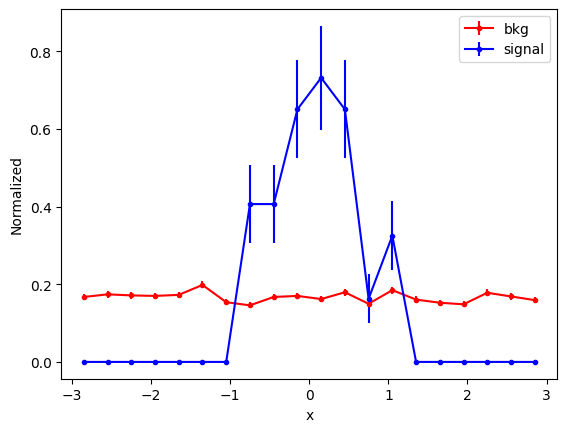

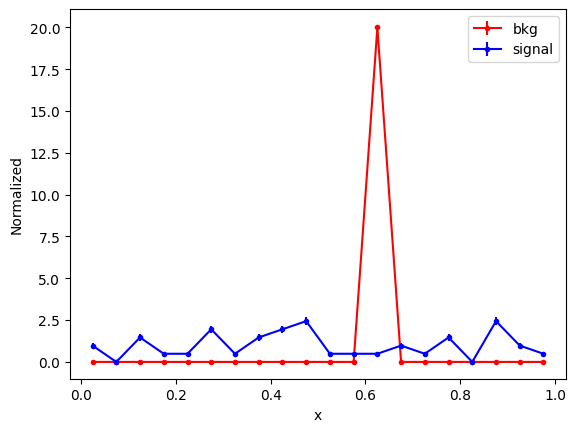

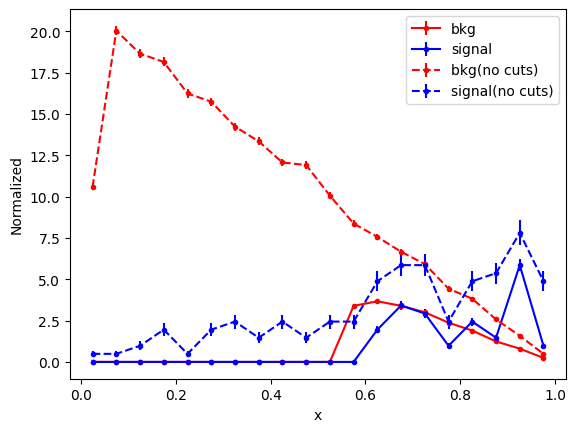

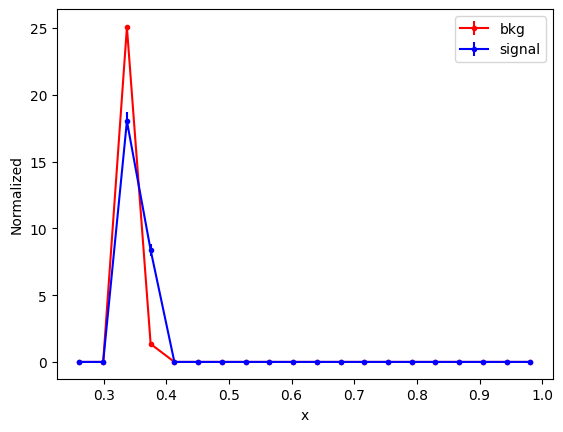

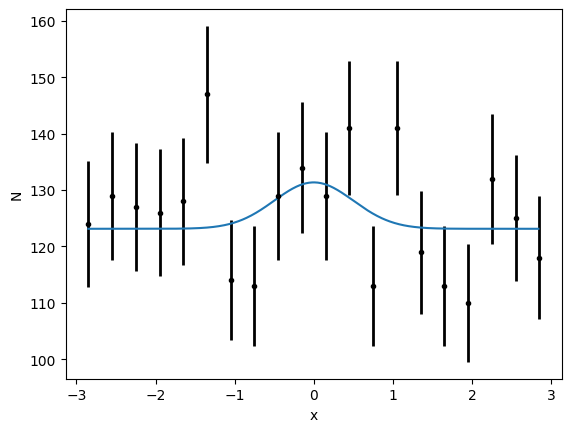

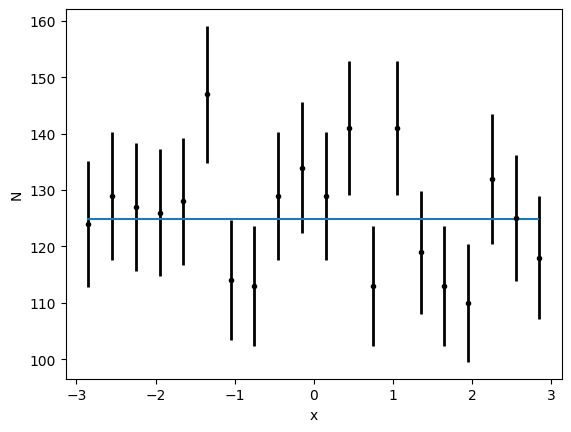

Delta negative Log Likelihood: 1.0851351772360296
Our Probability of this happening 0.29755161548302234
Expected Sig: 1.0416982179287961 expected lim: 19.81861312882919 events


In [276]:
def plotHistComp(iSig,iBkg,iGSig,iGBkg,iMin=-3,iMax=3):
    ns=len(iSig)
    nb=len(iBkg)
    ngs=len(iGSig)
    ngb=len(iGBkg)
    ys, bin_edges = np.histogram(iSig,density=True,bins=20,range=[iMin,iMax])#bins=bin_edges
    yb, bin_edges = np.histogram(iBkg, bins=bin_edges,density=True)
    ygs,bin_edges = np.histogram(iGSig, bins=bin_edges,density=True)
    ygb,bin_edges = np.histogram(iGBkg, bins=bin_edges,density=True)
    ygs*=len(iGSig)/len(iSig)
    ygb*=len(iGBkg)/len(iBkg)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers,yb,yerr=(nb*yb)**0.5/nb,marker='.',linestyle = '-', color = 'red',label='bkg')
    plt.errorbar(bin_centers,ys,yerr=(ns*ys)**0.5/ns,marker='.',linestyle = '-', color = 'blue',label='signal')
    plt.errorbar(bin_centers,ygb,yerr=(ngb/nb)*((ngb*ygb)**0.5)/ngb,marker='.',linestyle = '--', color = 'red',label='bkg(no cuts)')
    plt.errorbar(bin_centers,ygs,yerr=(ngs/ns)*((ngs*ygs)**0.5)/ngs,marker='.',linestyle = '--', color = 'blue',label='signal(no cuts)')
    plt.xlabel("x")
    plt.ylabel("Normalized")
    plt.legend()
    plt.show()
    
def plotDisc(iData,iOutput,iNSP,iNBP,iNSF,iNBF): #all the inputs for splitting data appropriately
    pSigData = torch.cat((iData  [0:iNSP],        iData  [iNSP+iNBP:iNSP+iNBP+iNSF]))
    pBkgData = torch.cat((iData  [iNSP:iNSP+iNBP],iData  [iNSP+iNBP+iNSF:-1]))
    pSigDisc = torch.cat((iOutput[0:iNSP],        iOutput[iNSP+iNBP:iNSP+iNBP+iNSF]))
    pBkgDisc = torch.cat((iOutput[iNSP:iNBP+iNSP],iOutput[iNSP+iNBP+iNSF:-1]))
    plotHist(pSigData[:,0],pBkgData[:,0],-3,3)
    plotHist(pSigData[:,1],pBkgData[:,1],0,1)
    plotHist(pSigData[:,2],pBkgData[:,2],0,1)
    plotHist(pSigDisc,pBkgDisc,0,1)
    cut=cutval(iOutput,p=0.9)
    cutsig = pSigDisc > cut
    cutbkg = pBkgDisc > cut
    plotHist(pSigData[cutsig][:,0],pBkgData[cutbkg][:,0],-3,3)
    plotHist(pSigData[cutsig][:,1],pBkgData[cutbkg][:,1],0,1)
    plotHistComp(pSigData[cutsig][:,2],pBkgData[cutbkg][:,2],pSigData[:,2],pBkgData[:,2],0,1)
    plotHist(pSigDisc[cutsig],pBkgDisc[cutbkg],cut-0.1,1.0)

class DataSet(Dataset):
    def __init__(self, samples, labels):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

class simple_MLP_onelayer(torch.nn.Module):
    def __init__(self,in_data,input_size,out_channels=1,act_out=True,nhidden=8,batchnorm=False,batch_size=100,n_epochs=50):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            #nn.Linear(nhidden, nhidden),
            #nn.ReLU(),
            nn.Linear(nhidden, out_channels),
        )
        self.loss    = nn.BCELoss()
        self.output  = torch.nn.Sigmoid()
        self.act_out = act_out
        self.batch_size = batch_size
        self.n_epochs     = n_epochs
        self.opt     = torch.optim.Adam(self.model.parameters(),lr=0.001)
        self.dataloader = DataLoader(in_data, batch_size=self.batch_size, shuffle=True)#,pin_memory=True)
        
    def forward(self, x):
        x = self.model(x)        
        if self.act_out:
            x = self.output(x)
        return x
    
    def training_mse_epoch(self):
        running_loss = 0.0
        updates=0
        for batch_idx, (x, y) in enumerate(self.dataloader):
            self.opt.zero_grad()
            #x     = x.cuda(); y = y.cuda()
            x = x.reshape((len(x),1))
            x_out = self.forward(x)
            loss  = self.loss(x_out.flatten(), y.flatten())
            loss.backward()
            #if batch_idx == 0: 
            #    print(batch_idx, x_out[0:10],x[0:10],y[0:10])
            #    print(loss)
            self.opt.step()
            running_loss += loss 
            updates = updates+1
        return running_loss/updates

    def training_mse(self):
        for epoch in range(self.n_epochs):
            self.model.train(True)
            loss_train = self.training_mse_epoch()
            #print('Epoch: {} LOSS train: {} '.format(epoch,loss_train))

#This sets up our data for training           
def makeDataSet(iD,iNS=1,iNB=1,iMLow=-1,iMHigh=1,iOutTrue=False,iTrueLabel=False):
    #1 is going to be sideband
    #2 is going to be mass range
    pD = iD.T
    dxcutS  = pD[(iD[0] > iMLow) & (iD[0] < iMHigh)]    
    dxcutB  = pD[(iD[0] < iMLow) | (iD[0] > iMHigh)]
    if iTrueLabel:
        dxcutS  = pD[0:iNS]
        dxcutB  = pD[iNS:-1]
    dxcutS  = torch.from_numpy(dxcutS)
    dxcutB  = torch.from_numpy(dxcutB)
    dxcutS  = dxcutS[torch.randperm(len(dxcutS))]
    dxcutB  = dxcutB[torch.randperm(len(dxcutB))]
    #now what we are going to do is split the dataset 
    nS=len(dxcutS)//2
    nB=len(dxcutB)//2
    tot1=torch.cat([dxcutS[0:nS,2],dxcutB[0:nB,2]])
    tot1=tot1.float()
    tot2=torch.cat([dxcutS[nS-1:-1,2],dxcutB[nB-1:-1,2]])
    tot2=tot2.float()
    #now merge sig and bkg and make dataset
    totfull1=torch.cat([dxcutS[0:nS],dxcutB[0:nB]])
    totfull1=totfull1.float()
    totfull2=torch.cat([dxcutS[nS-1:-1],dxcutB[nB-1:-1]])
    totfull2=totfull2.float()
    if iOutTrue:
        tD = torch.from_numpy(pD)
        totfull1=torch.cat([tD[0:iNS//2],tD[iNS:iNS+iNB//2]])
        totfull1=totfull1.float()
        totfull2=torch.cat([tD[iNS//2-1:iNS],tD[iNS+iNB//2-1:-1]])
        totfull2=totfull2.float()
    #now lets make labels
    siglabel1=torch.ones(nS)
    bkglabel1=torch.zeros(nB)
    label1=torch.cat((siglabel1,bkglabel1))
    siglabel2=torch.ones(len(dxcutS)-nS)
    bkglabel2=torch.zeros(len(dxcutB)-nB)
    label2=torch.cat((siglabel2,bkglabel2))
    #training datasets
    datatrain1=DataSet(samples=tot1,labels=label1)
    datatrain2=DataSet(samples=tot2,labels=label2)
    return datatrain1,datatrain2,totfull1,totfull2,nS*2,nB*2,iNS//2,iNB//2,iNS-iNS//2,iNB-iNB//2

#Note to actually be realistic we need to split data into pieces and train and apply
def expSigWeakToy(iS,iB,iPlot=True,iOutTrue=False):
    tdata = np.hstack((iS,iB))
    data1,data2,datafull1,datafull2,nS,nB,nTSP,nTBP,nTSF,nTBF=makeDataSet(tdata,len(iS[0]),len(iB[0]),iOutTrue=iOutTrue)
    #run two trainings
    rw_model0 = simple_MLP_onelayer(data1,1,out_channels=1,act_out=True,batchnorm=False)
    rw_model0.training_mse()
    rw_model1 = simple_MLP_onelayer(data2,1,out_channels=1,act_out=True,batchnorm=False)
    rw_model1.training_mse()
    #no2 inference
    output0=rw_model1.forward(datafull1[:,2].reshape(len(datafull1),1))
    output1=rw_model0.forward(datafull2[:,2].reshape(len(datafull2),1))
    output=torch.cat((output0,output1))
    datafull=torch.cat((datafull1,datafull2))
    xcut,ycut,cut=makeCutDataHist(datafull.T,output.flatten().detach().numpy())
    if iPlot:
        if iOutTrue:
            plotDisc(datafull,output.flatten().detach(),nTSP,nTBP,nTSF,nTBF)
        else:
            plotDisc(datafull,output.flatten().detach(),nS//2,nB//2,nS//2,nB//2)
    lim,amp=expLim(xcut,ycut,False)
    sigout=output[datafull[:,1] > 0]
    sig=sigout[sigout > cut]
    return significance(xcut,ycut,iPlot,iPlot),lim,amp,len(sig)

nb=25000
#pS,pB = genData(int(0.5*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

#pS,pB = genData(int(0.05*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

pS,pB = genData(int(0.005*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events",)

#pS,pB = genData(int(0.001*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

Now importantly we should check how things look with mass sideband trainings

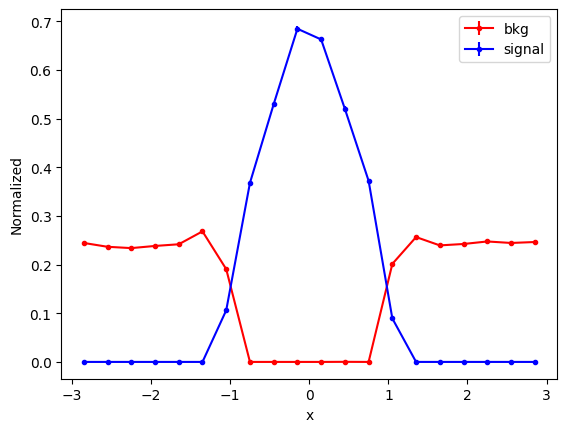

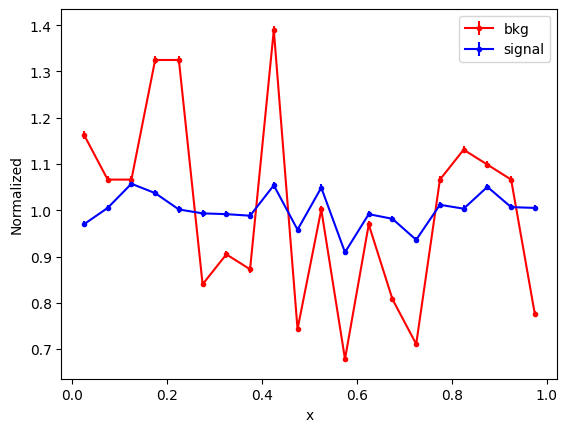

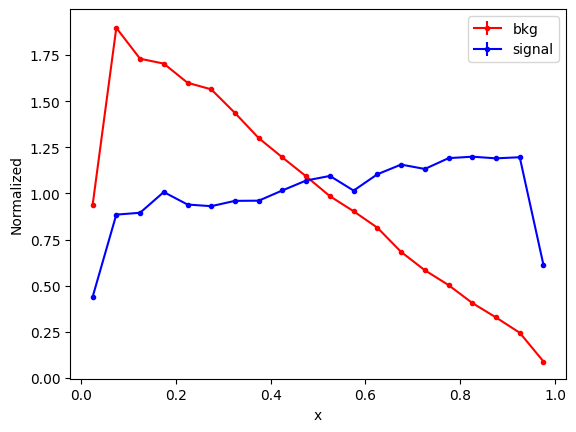

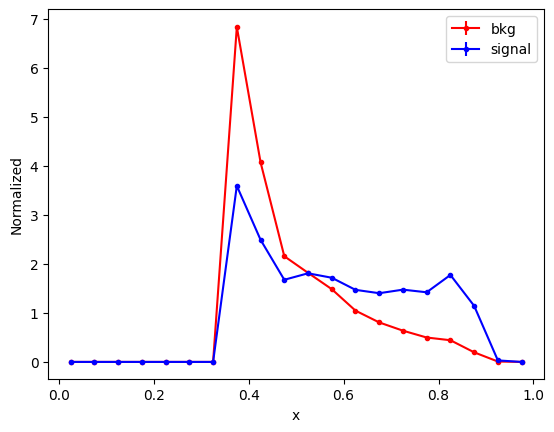

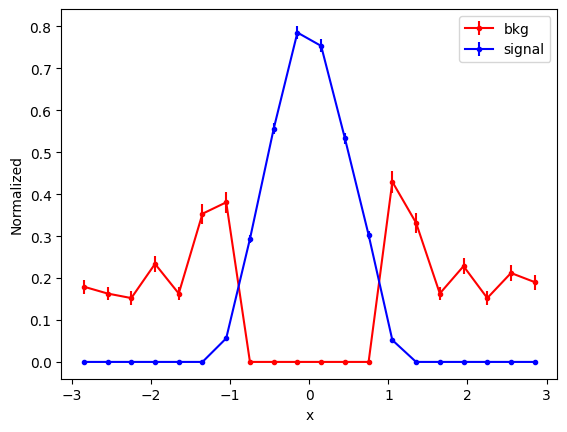

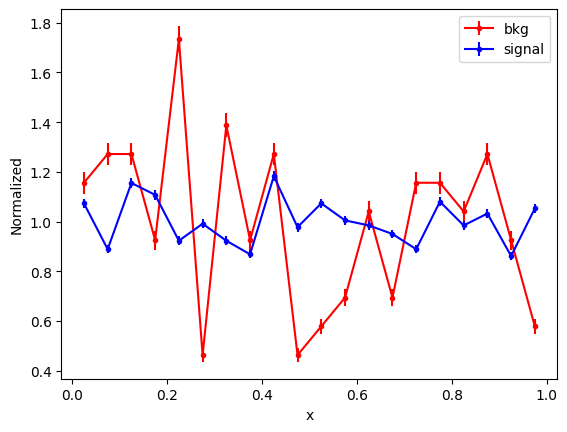

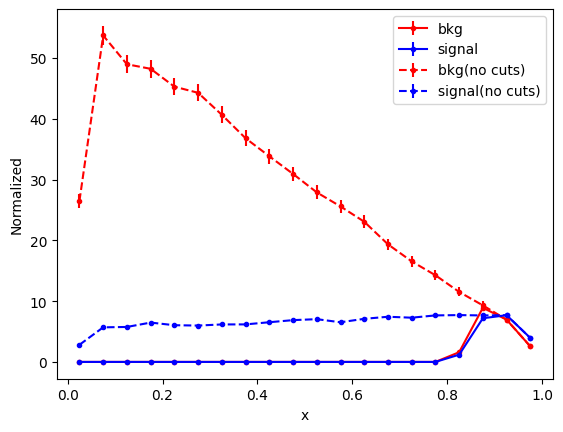

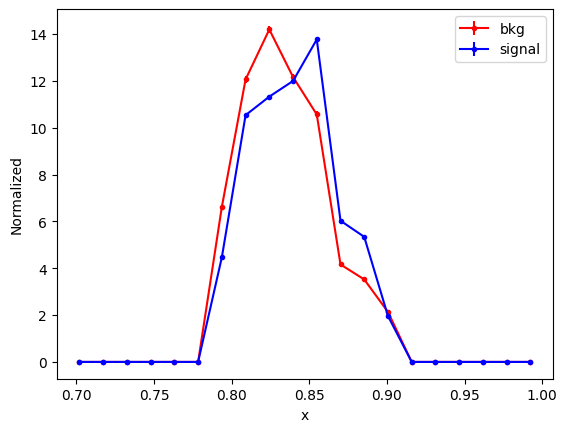

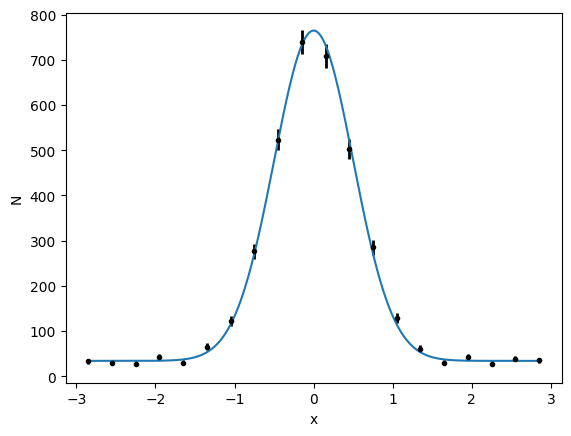

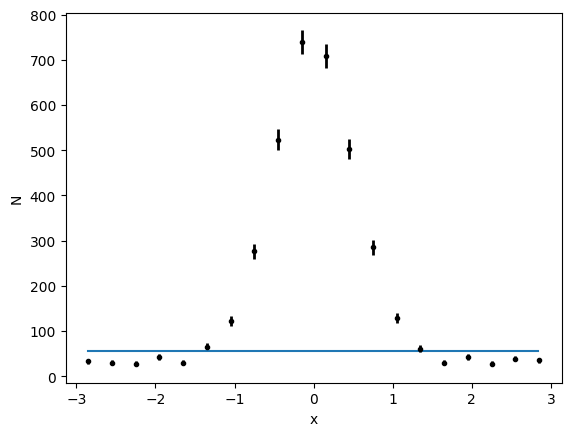

Delta negative Log Likelihood: 2633.795497430334
Our Probability of this happening 0.0
Expected Sig: inf expected lim: 35.69902100847297 events


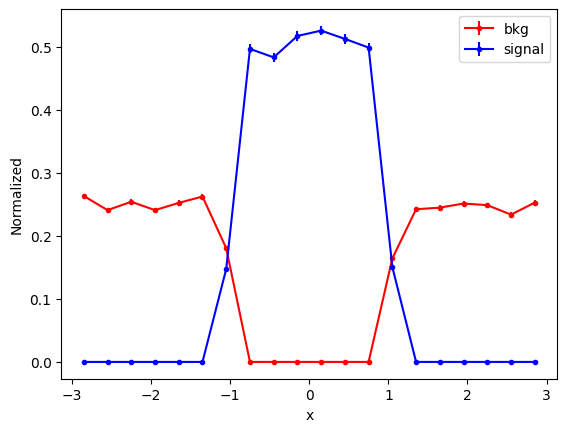

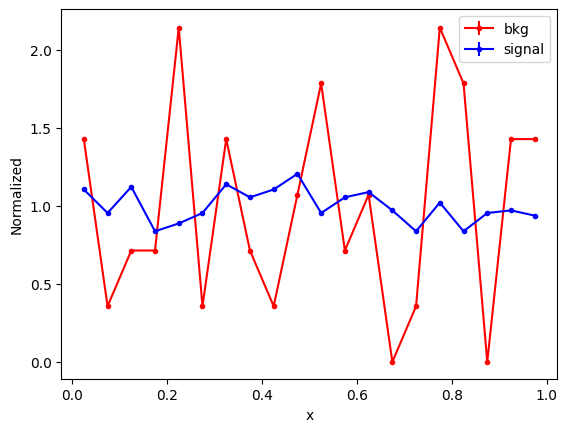

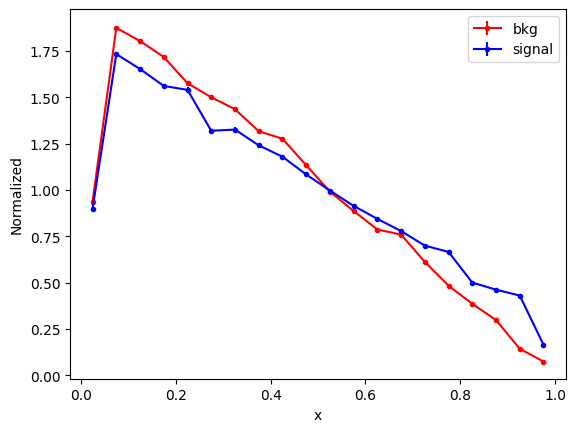

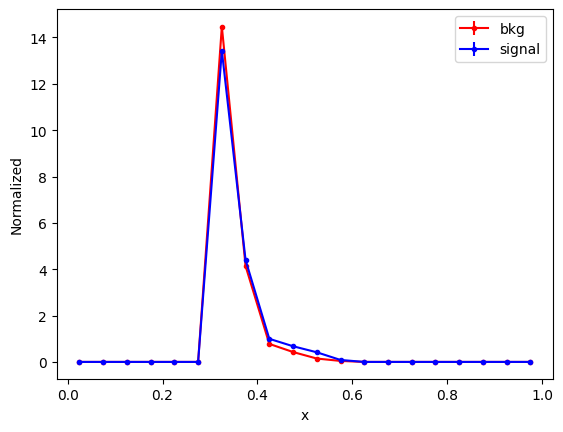

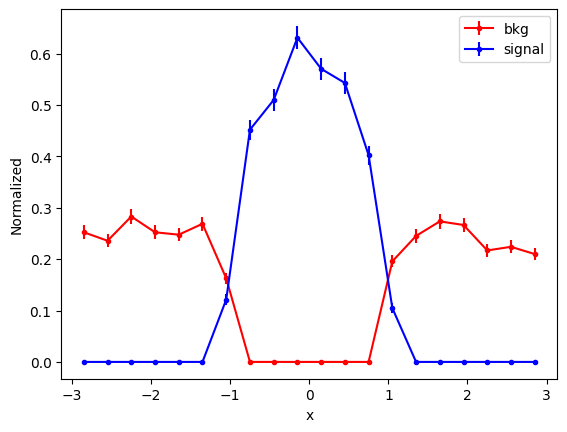

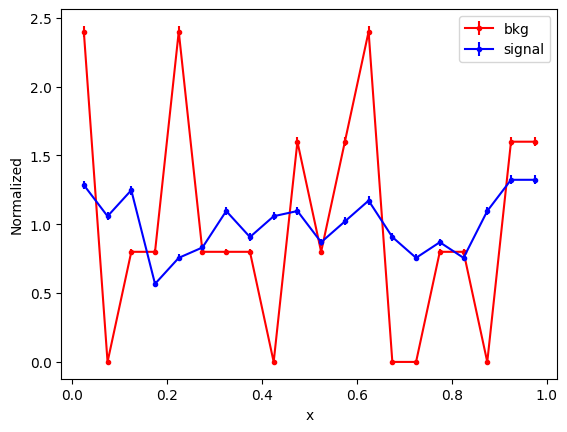

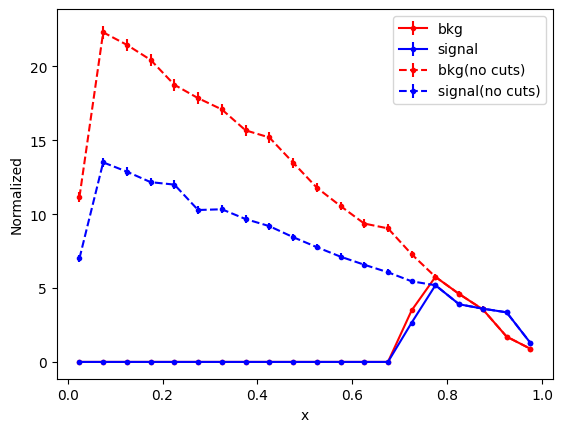

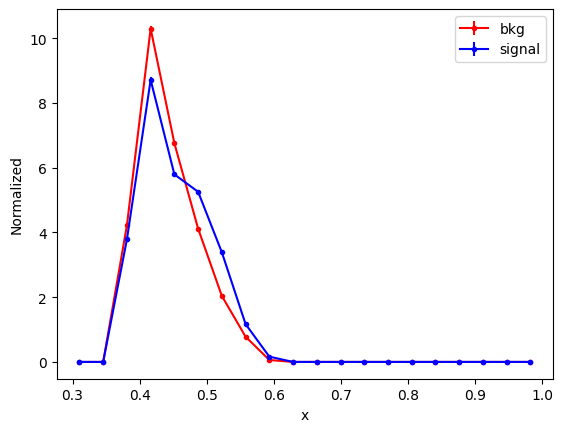

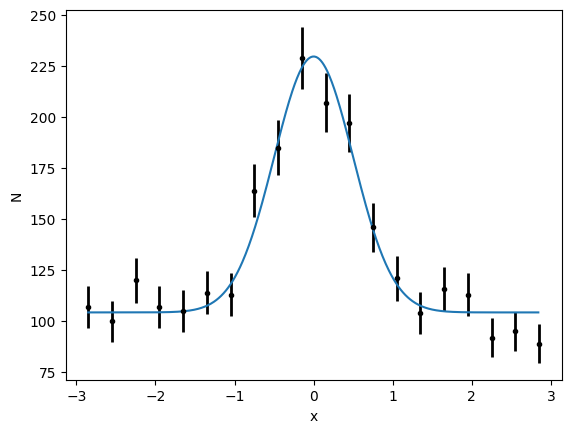

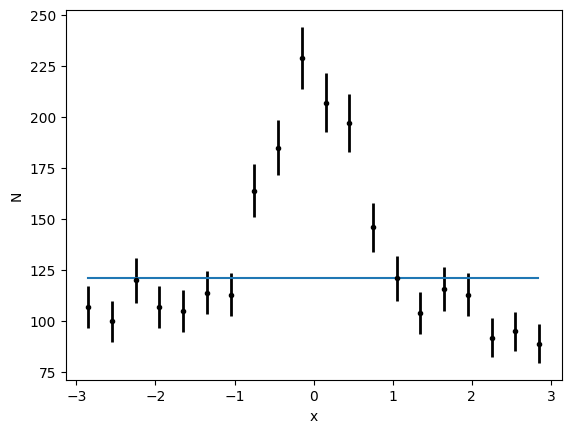

Delta negative Log Likelihood: 182.2227286731684
Our Probability of this happening 0.0
Expected Sig: inf expected lim: 23.29179854804423 events


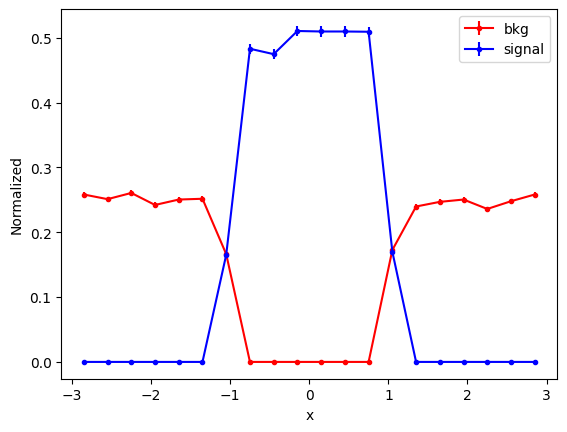

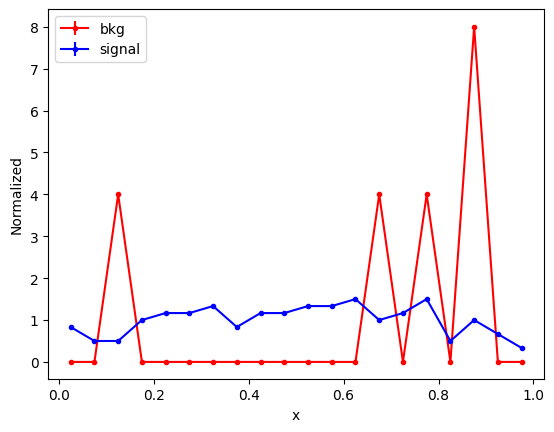

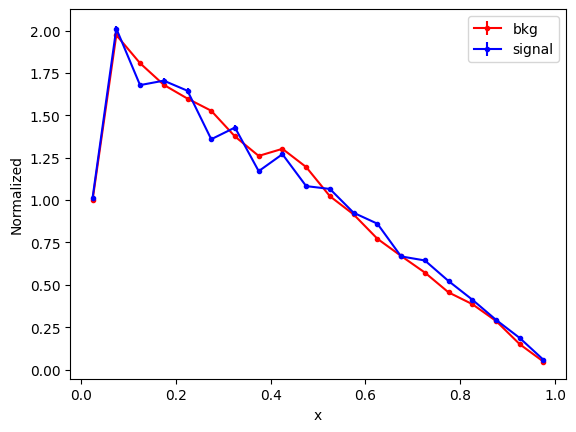

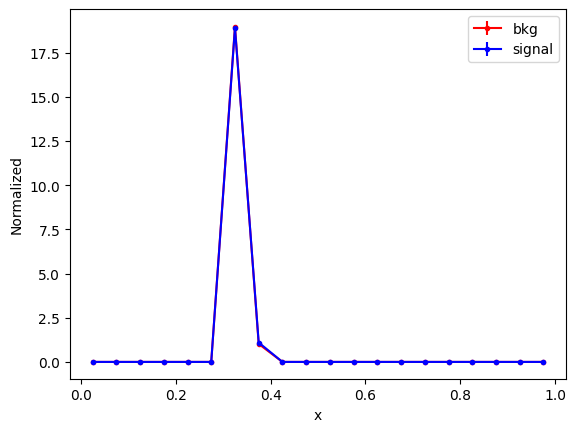

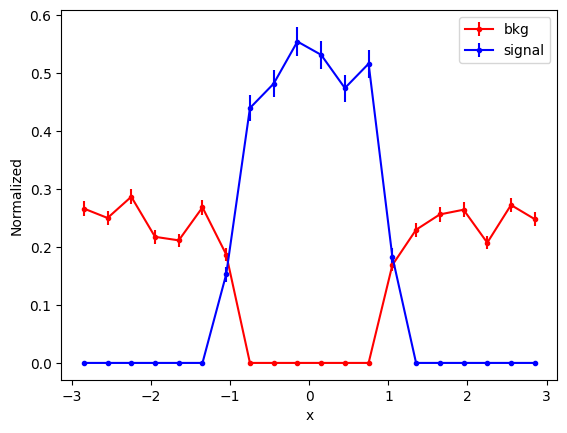

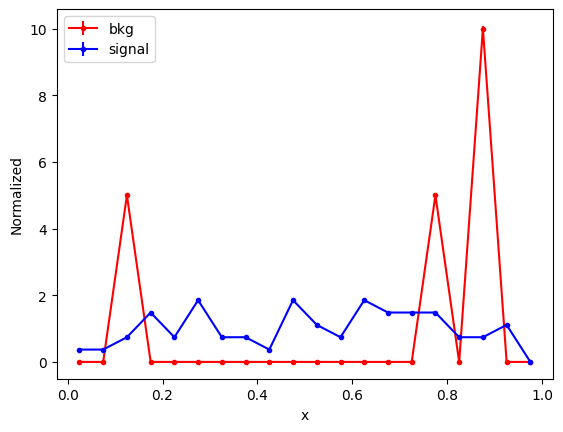

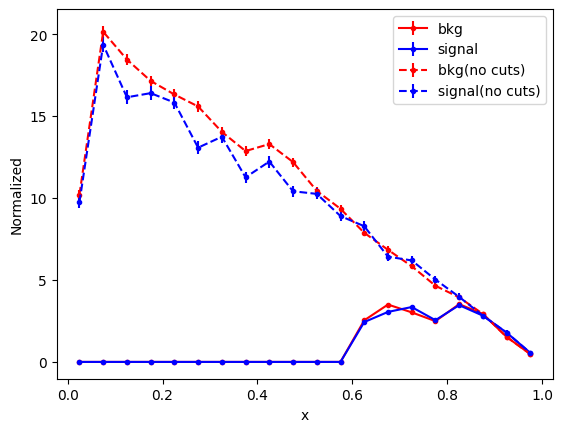

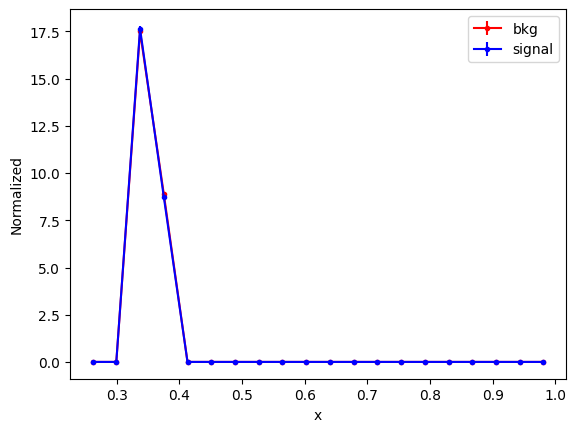

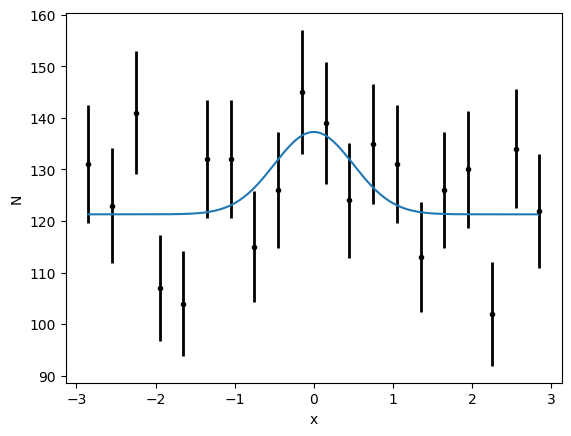

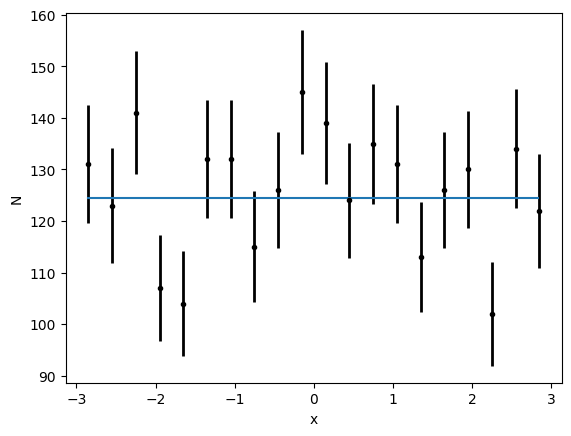

Delta negative Log Likelihood: 4.002378820115549
Our Probability of this happening 0.04543609421023154
Expected Sig: 2.00059461663665 expected lim: 19.9977156585155 events


In [277]:
pS,pB = genData(int(0.5*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

pS,pB = genData(int(0.05*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

pS,pB = genData(int(0.005*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

#pS,pB = genData(int(0.001*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

Ok now we have all the tools to run toys and compute limits and vary signals etc... Lets go ahead and start some comparisons of just a simple discriminator vs the NN cut

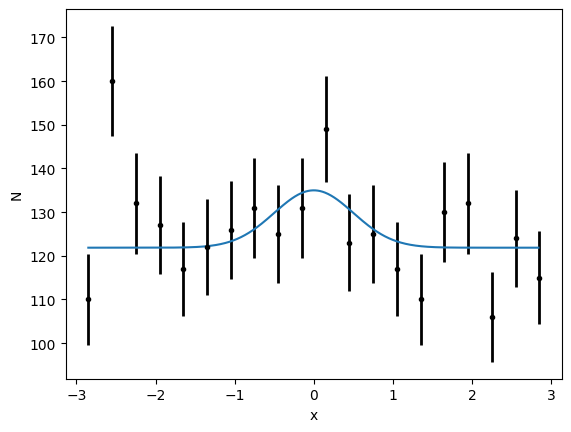

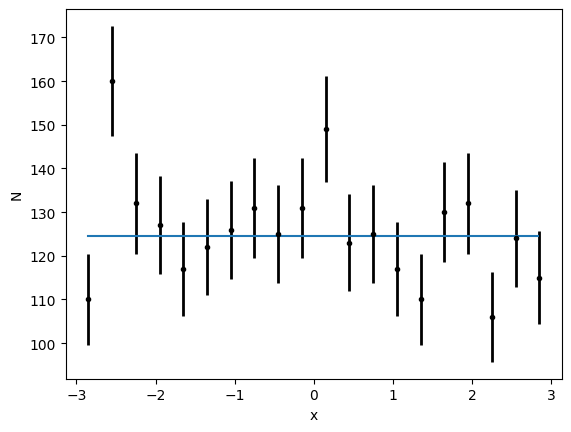

Delta negative Log Likelihood: 2.7276075293198403
Our Probability of this happening 0.0986269297661877


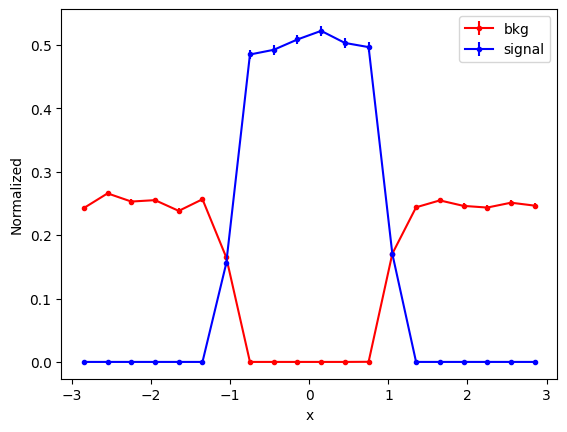

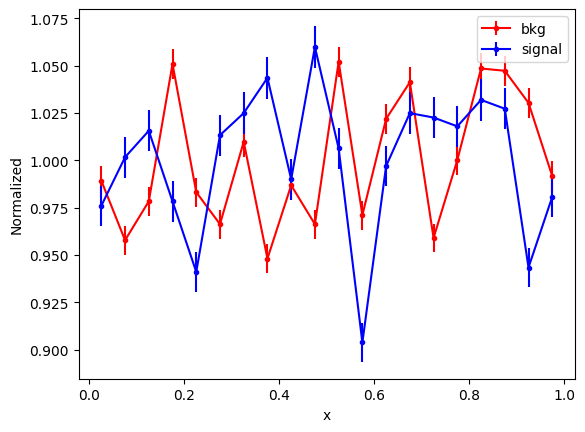

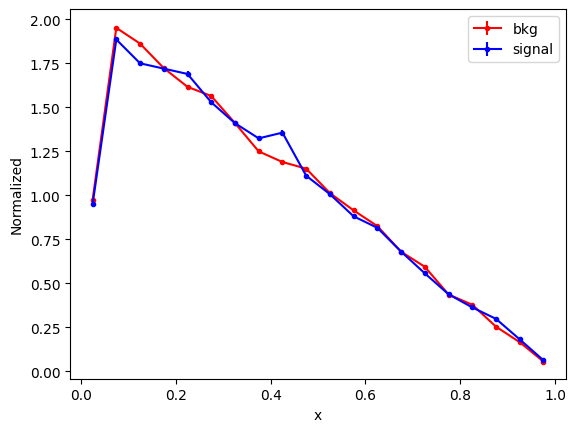

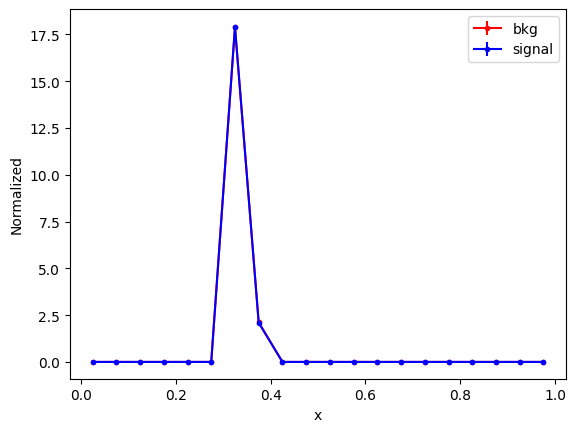

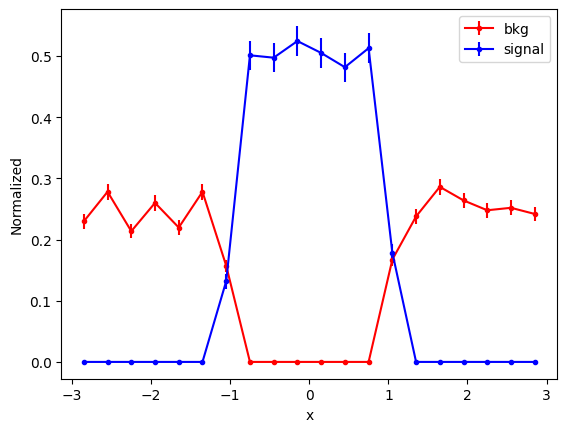

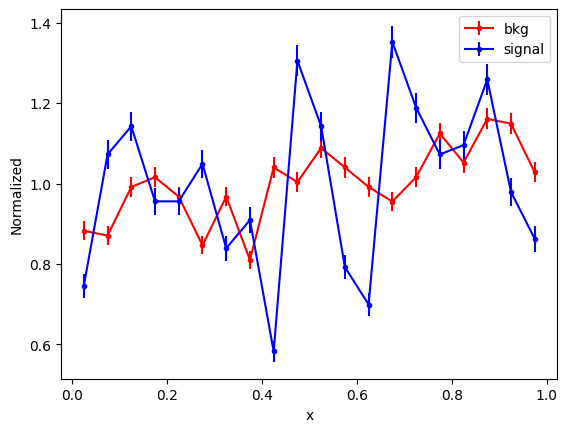

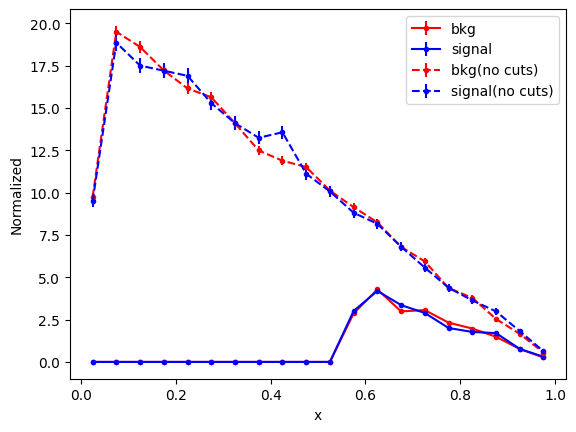

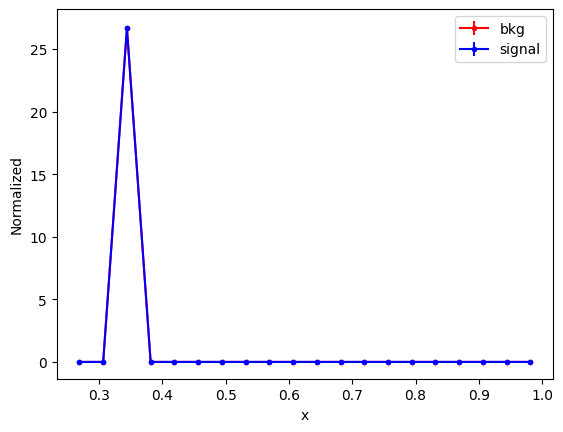

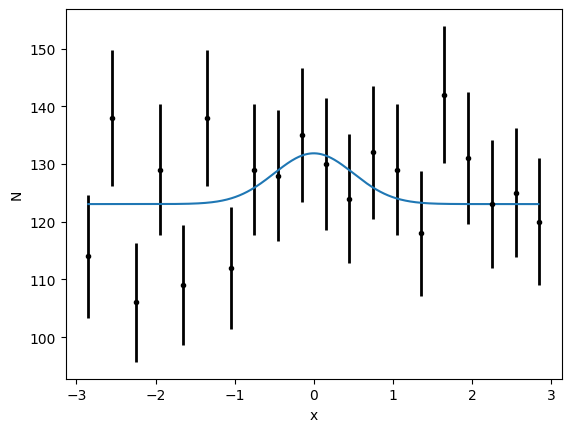

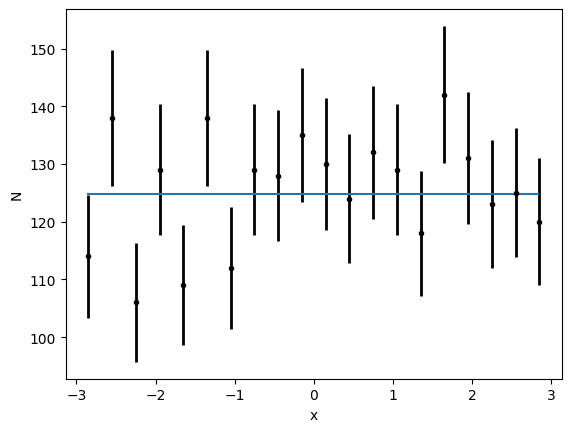

Delta negative Log Likelihood: 1.250720233042502
Our Probability of this happening 0.2634149612572243
Exp sig: 2.7276075293198403 Weak sig: 1.250720233042502
Exp lim: 19.91718916381415 Weak lim: 19.72624583867711


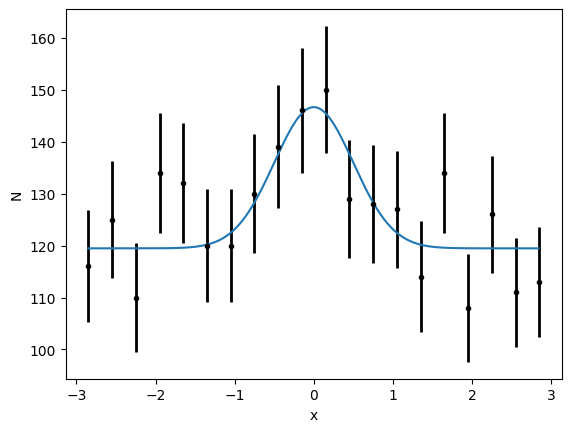

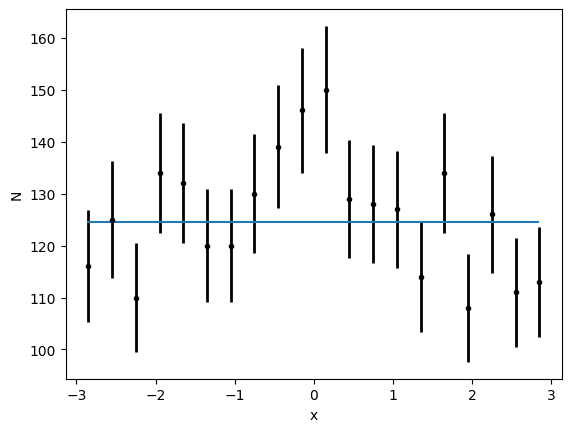

Delta negative Log Likelihood: 11.18434149039423
Our Probability of this happening 0.0008249052738295015


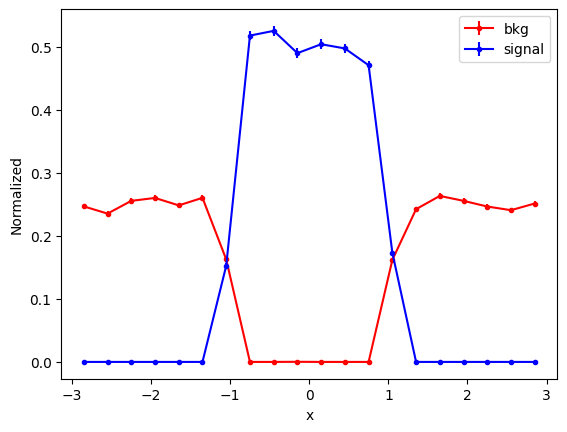

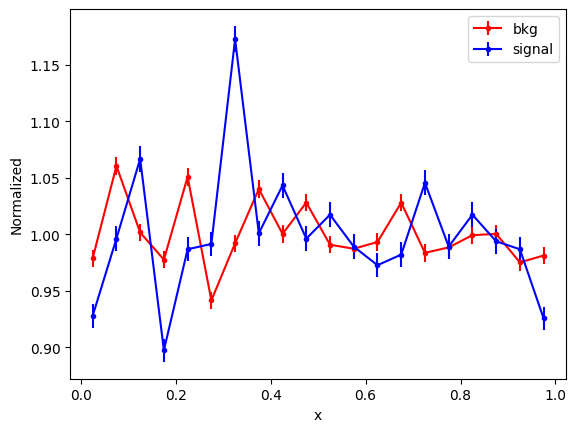

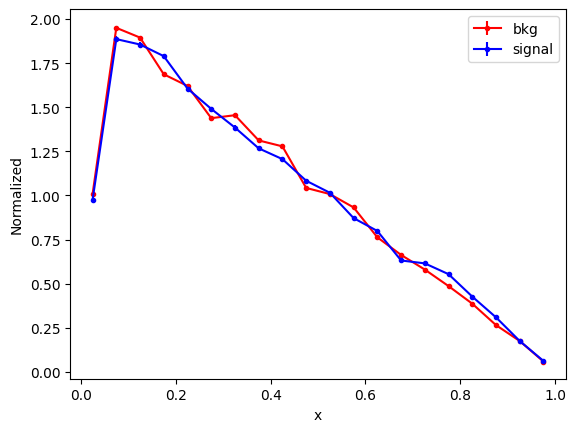

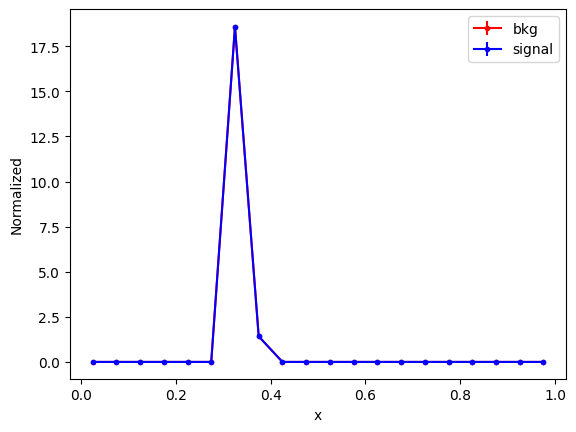

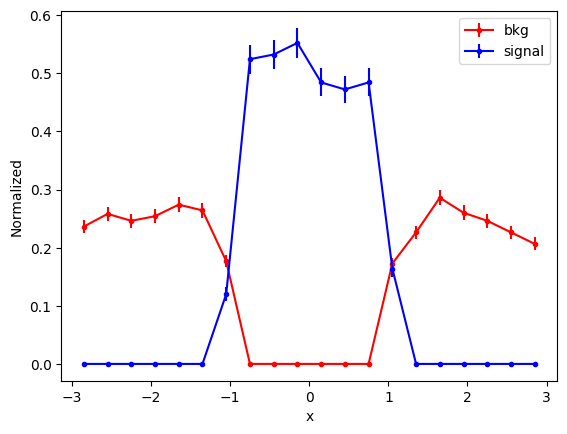

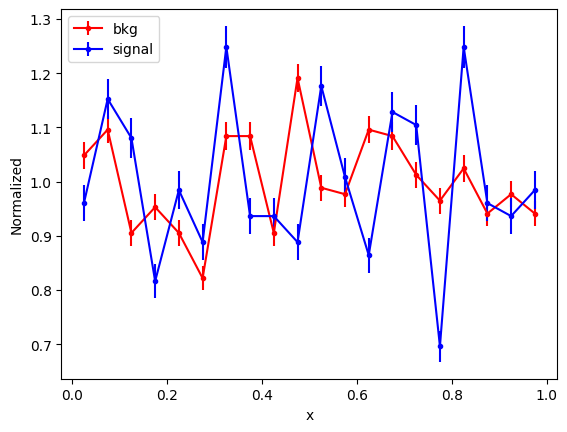

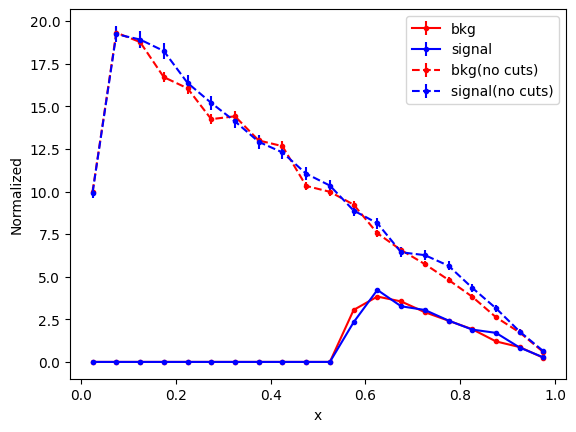

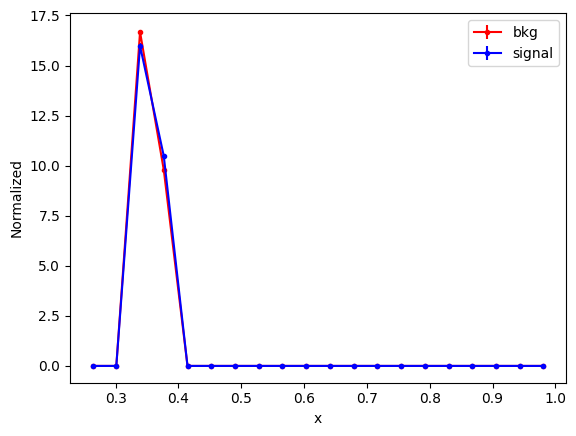

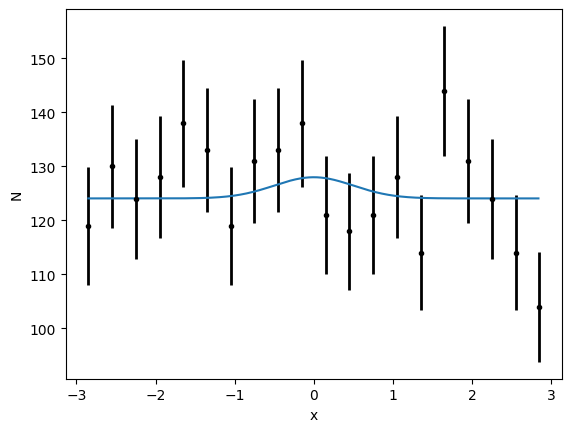

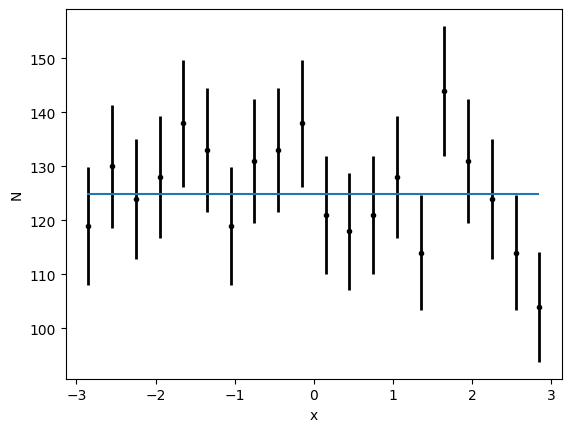

Delta negative Log Likelihood: 0.25199805159375543
Our Probability of this happening 0.6156716885999323
Exp sig: 11.18434149039423 Weak sig: 0.25199805159375543
Exp lim: 20.360867327906096 Weak lim: 19.58692070922877


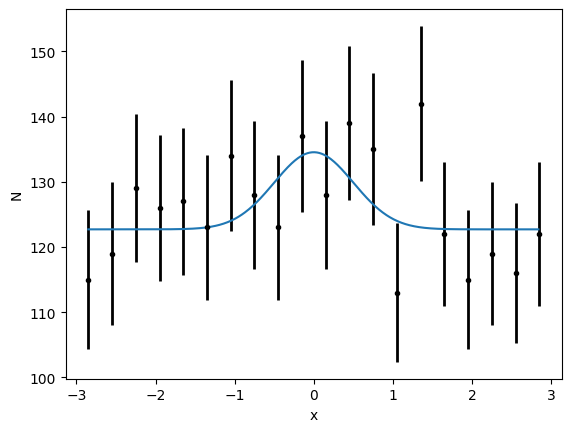

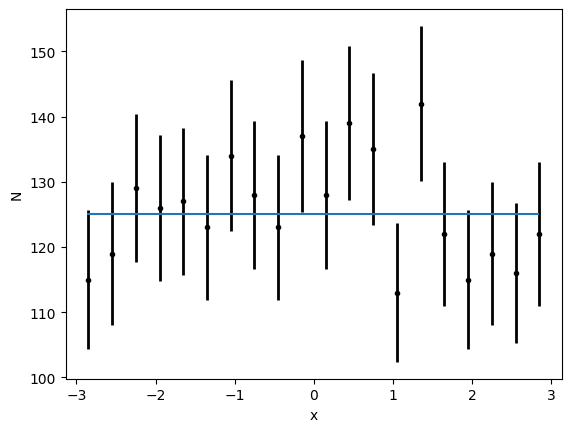

Delta negative Log Likelihood: 2.252365807669401
Our Probability of this happening 0.1334103011222756


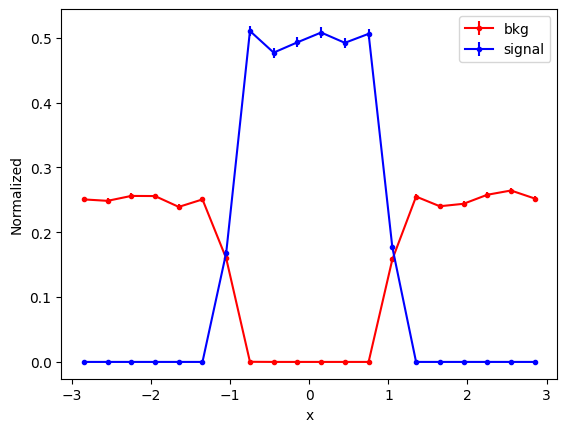

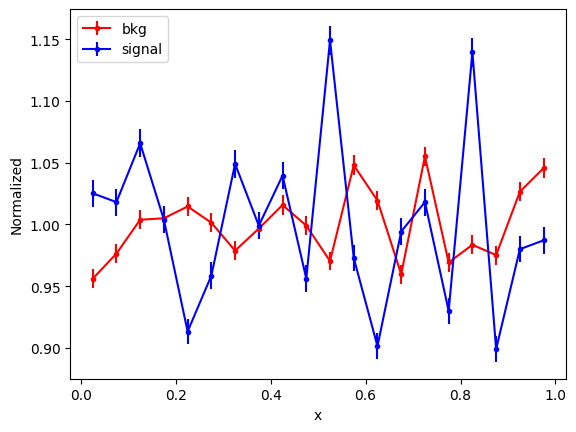

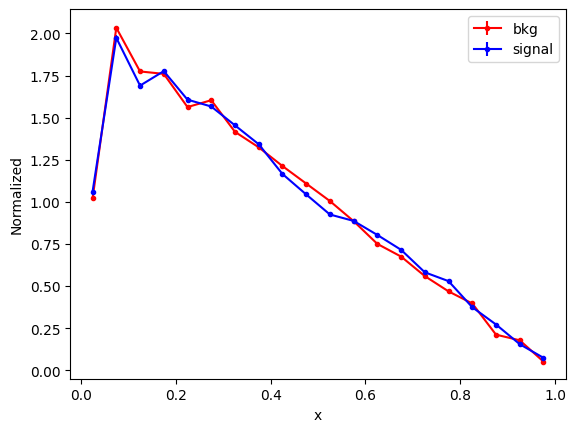

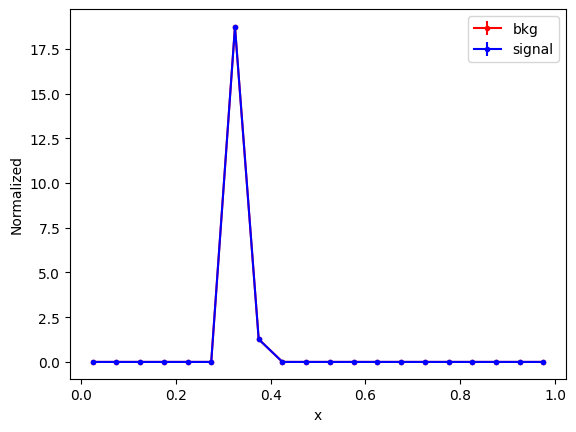

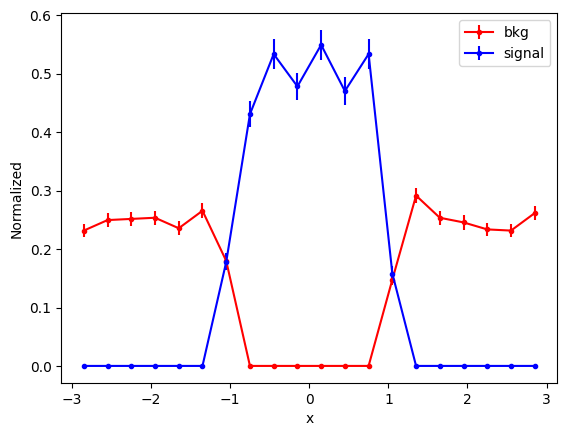

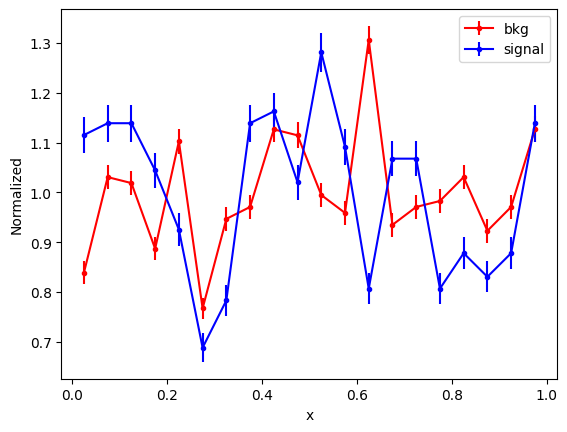

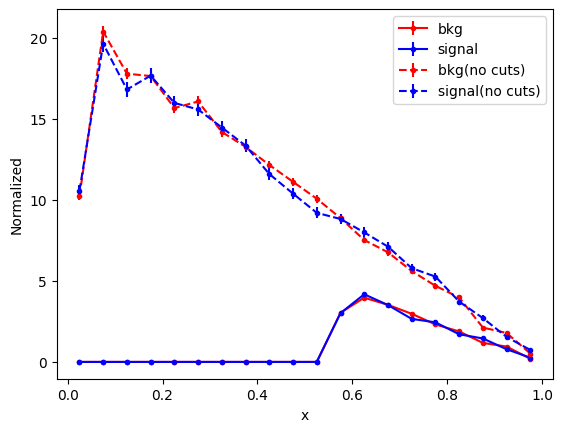

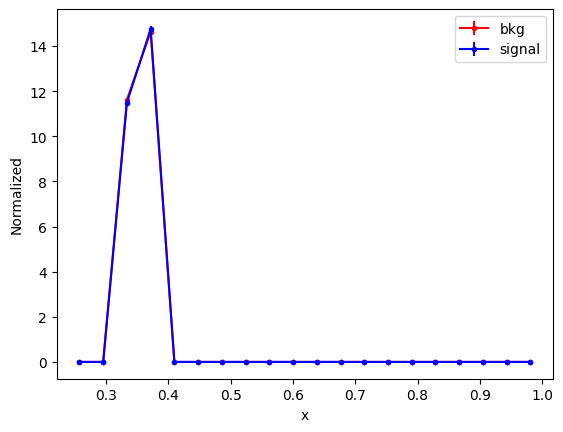

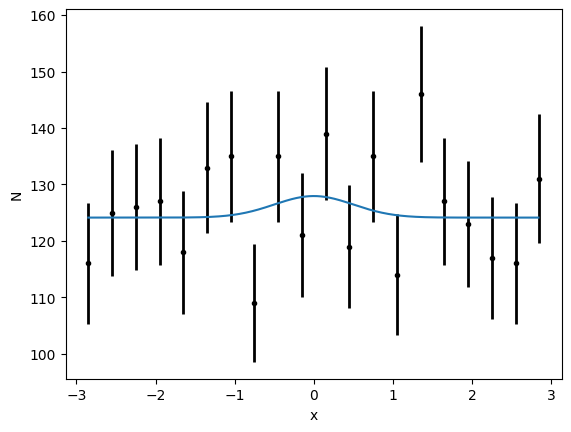

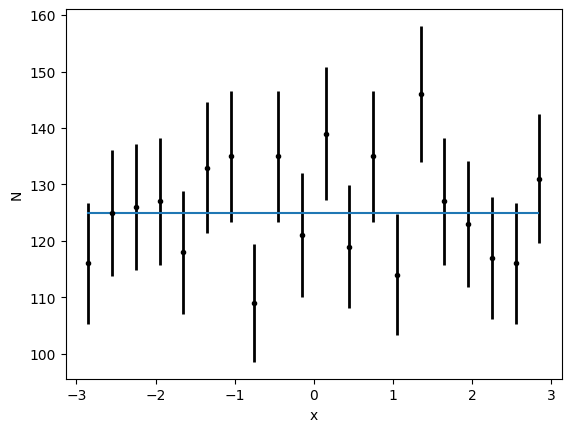

Delta negative Log Likelihood: 0.23791407031367307
Our Probability of this happening 0.6257167589326063
Exp sig: 2.252365807669401 Weak sig: 0.23791407031367307
Exp lim: 19.763296827864735 Weak lim: 19.62240542566598


In [221]:
nb=25000

def printOutput(iNS,iNB):
    pS,pB = genData(iNS,iNB)
    pVExpSig,    pVLim,    pVAmp,pVSig=expSigToy(pS,pB,True)
    pVExpWeakSig,pVWeakLim,pVWeakAmp,pVWeakSig=expSigWeakToy(pS,pB,True)
    print("Exp sig:",pVExpSig,"Weak sig:",pVExpWeakSig)
    print("Exp lim:",pVLim,   "Weak lim:",pVWeakLim)
    
#printOutput(int(0.5*nb),nb)
#printOutput(int(0.05*nb),nb)
#printOutput(int(0.02*nb),nb)
#printOutput(int(0.01*nb),nb)
printOutput(int(0.005*nb),nb)
printOutput(int(0.005*nb),nb)
printOutput(int(0.005*nb),nb)
#printOutput(int(0.001*nb),nb)

Now we can compute a whole stack of toys with this guy to start to make general conclusions. 

0
!!! 2512
1
!!! 2512
2
!!! 2512
3
!!! 2512
4
!!! 2512
5
!!! 2512
6
!!! 2512
7
!!! 2512
8
!!! 2512
9
!!! 2512
10
!!! 2512
11
!!! 2512
12
!!! 2512
13
!!! 2512
14
!!! 2512
15
!!! 2511
16
!!! 2512
17
!!! 2512
18
!!! 2511
19
!!! 2512
20
!!! 2512
21
!!! 2512
22
!!! 2512
23
!!! 2512
24
!!! 2512
25
!!! 2512
26
!!! 2512
27
!!! 2512
28
!!! 2512
29
!!! 2512
30
!!! 2512
31
!!! 2512
32
!!! 2512
33
!!! 2512
34
!!! 2512
35
!!! 2512
36
!!! 2512
37
!!! 2512
38
!!! 2512
39
!!! 2512
40
!!! 2512
41
!!! 2512
42
!!! 2512
43
!!! 2512
44
!!! 2512
45
!!! 930
46
!!! 2512
47
!!! 2394
48
!!! 2512
49
!!! 2512
Fit: 0.59844767372587  rms: 0.4410883743318903
Weak: 1.299418773733772  rms: 0.8550940404606994


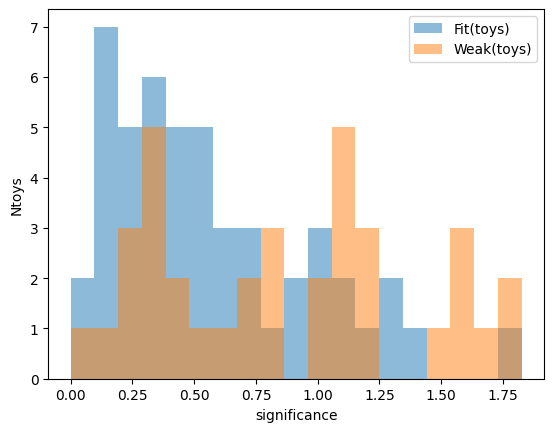

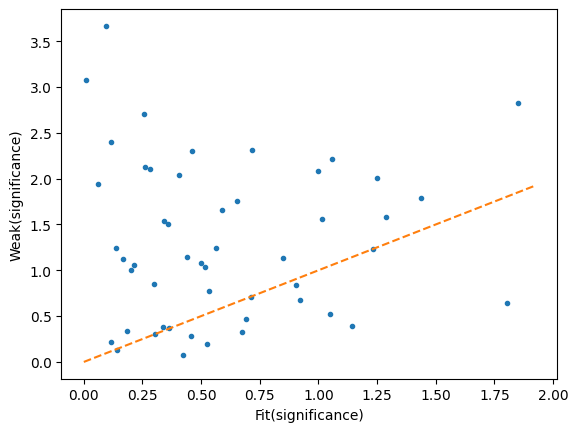

Fit: 19.405574315283516  rms: 0.2206775372503611
Weak: 19.543290312202835  rms: 1.079847954027986


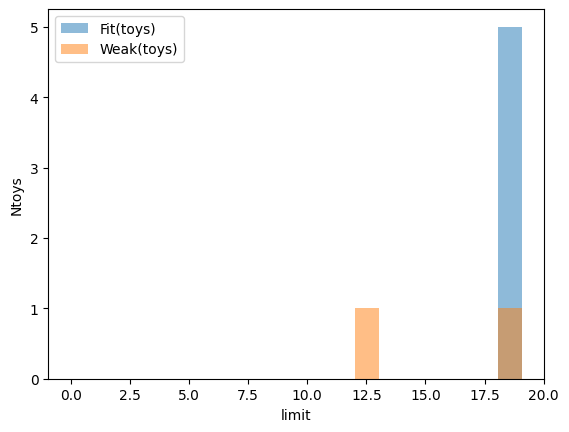

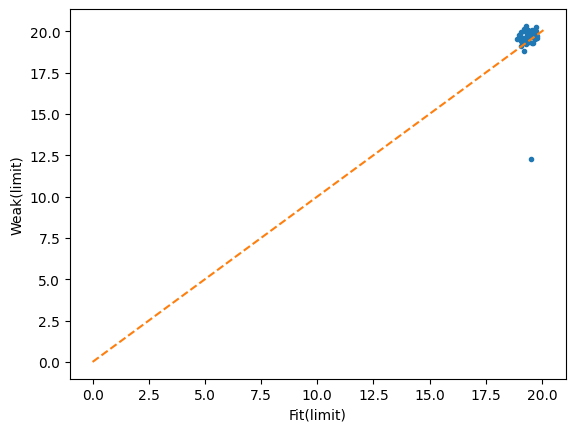

Fit: 0.2797306110799238  rms: 7.231566001394583
Weak: 11.498699548006794  rms: 10.246098674780399


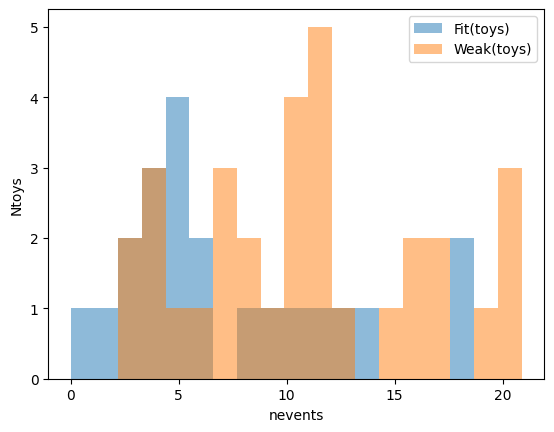

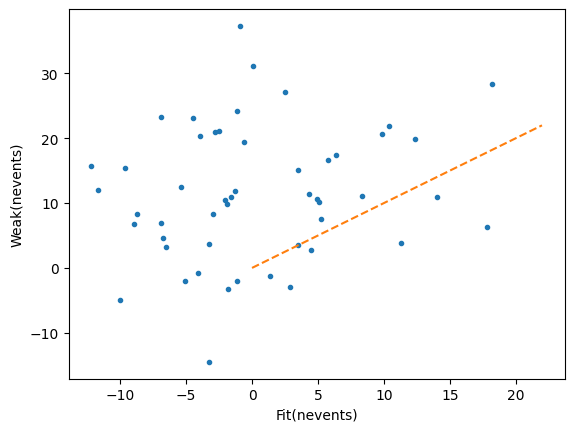

Fit: 0.78  rms: 0.8316249154516716
Weak: 2477.96  rms: 221.75274158395425


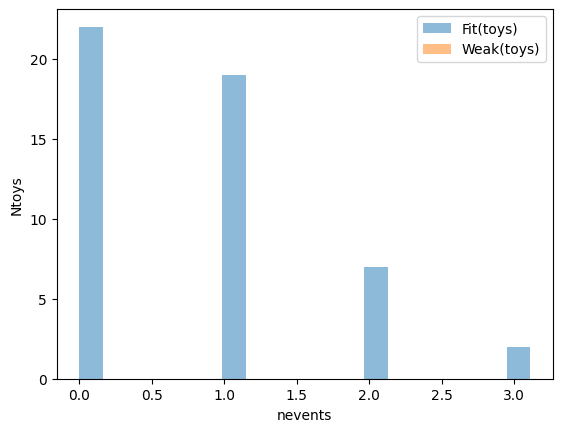

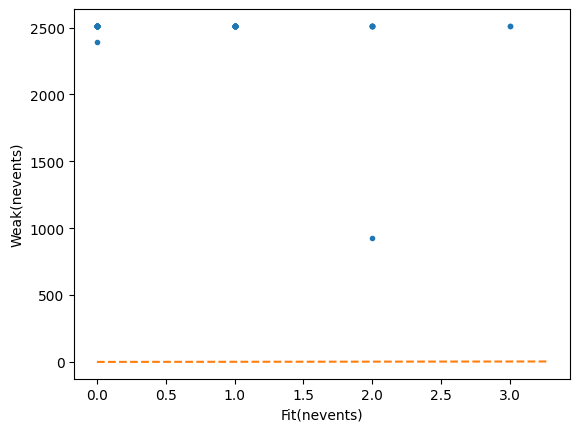

In [288]:
def plotToyHist(iFit,iWeak,label="x"):
    print("Fit:",np.mean(iFit),  " rms:",np.std(iFit))
    print("Weak:",np.mean(iWeak)," rms:",np.std(iWeak))
    maxvalue=np.mean(iFit)+3*np.std(iFit)
    bins=np.arange(0,maxvalue,maxvalue/20)
    plt.hist(iFit,bins=bins,alpha=0.5,label='Fit(toys)')
    plt.hist(iWeak,bins=bins,alpha=0.5,label='Weak(toys)')
    plt.xlabel(label)
    plt.ylabel("Ntoys")
    plt.legend()
    plt.show()

    xvals=[0,maxvalue]
    plt.plot(iFit,iWeak,'.',label='toys')
    plt.plot(xvals,xvals,'--')
    plt.xlabel("Fit("+label+")")
    plt.ylabel("Weak("+label+")")
    plt.show()

def Toy(iNS,iNB):
    pS,pB = genData(iNS,iNB)
    pVExpSig,    pVLim,    pVAmp,    pVSig=expSigToy(pS,pB,False)
    pVExpWeakSig,pVWeakLim,pVWeakAmp,pVWeakSig=expSigWeakToy(pS,pB,False)
    return pVExpSig,pVExpWeakSig,pVLim,pVWeakLim,pVAmp,pVWeakAmp,pVSig,pVWeakSig

def runToys(iNS,iNB,iNToys):
    expSig=np.array([])
    expWeakSig=np.array([])
    expLim=np.array([])
    expWeakLim=np.array([])
    expAmp=np.array([])
    expWeakAmp=np.array([])
    expNSig=np.array([])
    expWeakNSig=np.array([])
    for pToy in range(iNToys):
        print(pToy)
        pVExpSig,pVExpWeakSig,pVLim,pVWeakLim,pVAmp,pVWeakAmp,pVSig,pVWeakSig=Toy(iNS,iNB)
        expSig=    np.append(expSig,    pVExpSig)
        expWeakSig=np.append(expWeakSig,pVExpWeakSig)
        expLim=    np.append(expLim,    pVLim)
        expWeakLim=np.append(expWeakLim,pVWeakLim)
        expAmp=    np.append(expAmp,    pVAmp)
        expWeakAmp=np.append(expWeakAmp,pVWeakAmp)
        expNSig=    np.append(expNSig,    pVSig)
        expWeakNSig=np.append(expWeakNSig,pVWeakSig)
        print("!!!",pVWeakSig)
    return expSig,expWeakSig,expLim,expWeakLim,expAmp,expWeakAmp,expNSig,expWeakNSig
    
nb=25000
ntoys=50
sigToys,sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys,nsigToys,nsigWeakToys=runToys(int(0.005*nb),nb,ntoys)
plotToyHist(sigToys,sigWeakToys,label='significance')
plotToyHist(limToys,limWeakToys,label='limit')
plotToyHist(ampToys,ampWeakToys,label='nevents')
plotToyHist(nsigToys,nsigWeakToys,label='nevents')

Now lets consider an alternative scenario where we jus swap the signal to be on the other side, and we cut incorrectly when we do the cut based. 

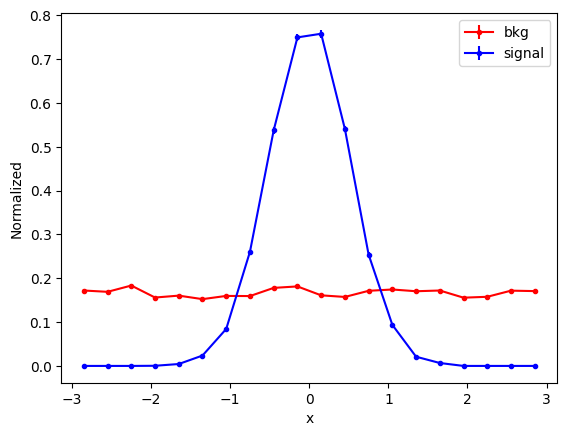

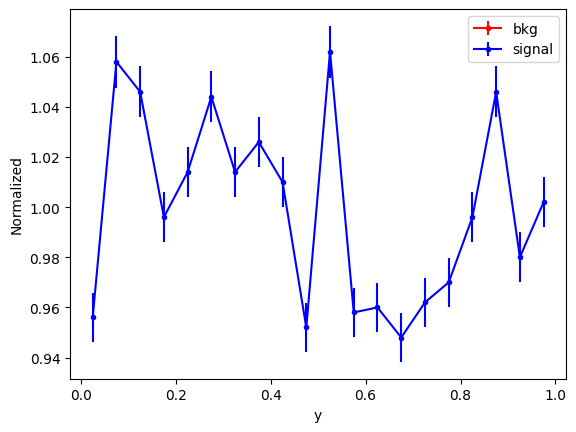

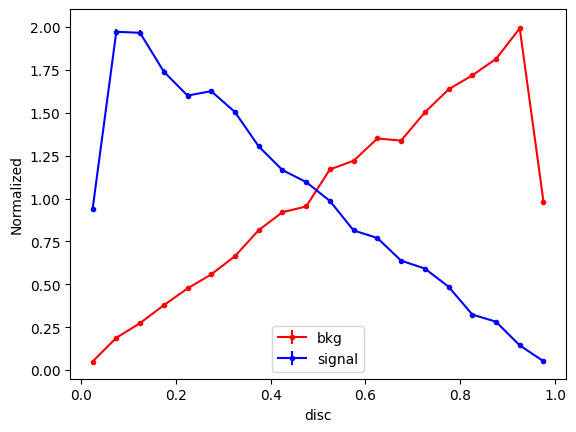

In [289]:
def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0,1,iNS)
    sz=np.random.triangular(0,0.05,1,iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,0,iNB)
    bz=np.random.triangular(0.,0.95, 1, iNB)
    b=np.vstack([bx,by,bz])
    return s,b

sig,bkg=genData(10000,10000)
plotHist(sig[0],bkg[0],label="x")
plotHist(sig[1],bkg[1],0,1,label="y")
plotHist(sig[2],bkg[2],0,1,label="disc")

Now lets run some toys of all of this

In [291]:
nb=25000
ntoys=50

sigToys,sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys,nsigToys,nsigWeakToys=runToys(int(0.005*nb),nb,ntoys)
plotToyHist(sigToys,sigWeakToys,label='significance')
plotToyHist(limToys,limWeakToys,label='limit')
plotToyHist(ampToys,ampWeakToys,label='nevents')
plotToyHist(nsigToys,nsigWeakToys,label='nevents')

0


ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

Finally, we can do the limit computation

In [ ]:
nb=25000
ntoys=50

def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0,1,iNS)
    sz=np.random.triangular(0.,0.95, 1, iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,0,iNB)
    bz=np.random.triangular(0,0.05,1,iNB)
    b=np.vstack([bx,by,bz])
    return s,b

sigs=[0.0001,0.0005,0.001,0.002,0.003,0.005,0.006,0.007,0.008]
sigToysTot=np.array([])
sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys

sigToys,sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys=runToys(int(0.005*nb),nb,ntoys)
plotToyHist(sigToys,sigWeakToys,label='significance')
plotToyHist(limToys,limWeakToys,label='limit')
plotToyHist(ampToys,ampWeakToys,label='nevents')


In [232]:
def convert(NLL):
    p   = 1-stats.chi2.cdf(NLL, 1)
    z   = -1*stats.norm.ppf(p/2.)
    print(z)
    
convert(11.1)
convert(2.7)
convert(2.3)
convert(1.3)
convert(0.2)
convert(0.3)
convert(12.7)
convert(12.8)
convert(172)
convert(170)
convert(2750)
convert(2752)
convert(0.5)
convert(0.3)

3.3316662497915184
1.6431676725154993
1.5165750888103107
1.1401754250991387
0.4472135954999582
0.5477225575051664
3.5637059362410524
3.577708763999662
inf
inf
inf
inf
0.7071067811865477
0.5477225575051664
